In [25]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()
%matplotlib inline
plt.rcParams['agg.path.chunksize'] = 10000

# 1. Import all CSVs

In [26]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()
%matplotlib inline
plt.rcParams['agg.path.chunksize'] = 10000

In [27]:
from pathlib import Path

pathlist = Path('safety/features').glob('**/*.csv')
li = []

for path in pathlist:
    path_in_str = str(path)
    li.append(pd.read_csv(path_in_str))

data = pd.concat(li, axis=0, ignore_index=True)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16135561 entries, 0 to 16135560
Data columns (total 11 columns):
bookingID         int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtypes: float64(10), int64(1)
memory usage: 1.3 GB


## 1.1. Add additional columns

In [29]:
data['Distance'] = data['Speed'] * data['second']
data['Acceleration'] = np.sqrt(np.power(data['acceleration_x'], 2) + np.power(data['acceleration_y'], 2) + np.power(data['acceleration_z'], 2))
data['Magnitude'] = np.sqrt(np.power(data['gyro_x'], 2) + np.power(data['gyro_y'], 2) + np.power(data['gyro_z'], 2))

## 1.2. Append labels to main dataset

In [30]:
labels = pd.read_csv('safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

dangerousCol = []

for row in data['bookingID']:
    if row not in labels['bookingID']:
        dangerousCol.append(None)
    else:
        dangerousCol.append(labels.loc[row, 'label'])
            
data['Dangerous'] = dangerousCol
data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,Distance,Acceleration,Magnitude,Dangerous
0,1194000908341,4.000,203.000000,1.001973,9.745000,-0.790087,-0.066046,0.019175,0.044741,246.0,6.480000,1594.080000,9.828185,0.082046,NaN
1,1099511627891,3.000,311.000000,0.452518,9.273026,3.098191,0.005382,0.002155,-0.001436,66.0,0.340365,22.464121,9.787368,0.005972,NaN
2,962072674446,10.000,142.807999,0.018542,-8.041156,-4.960114,0.004223,-0.014875,0.007397,1552.0,2.050000,3181.599926,9.447924,0.017141,NaN
3,1142461300867,8.000,171.205292,-0.290698,-8.295367,-3.049042,0.033618,0.046224,0.030559,277.0,17.608448,4877.540104,8.842753,0.064813,NaN
4,412316860548,19.379,0.000000,0.675613,8.846130,1.852508,-0.008652,0.003693,0.001160,148.0,0.000000,0.000000,9.063237,0.009478,NaN


## 1.3. Drop rows with null values

In [31]:
data.isnull().sum()

bookingID                0
Accuracy                 0
Bearing                  0
acceleration_x           0
acceleration_y           0
acceleration_z           0
gyro_x                   0
gyro_y                   0
gyro_z                   0
second                   0
Speed                    0
Distance                 0
Acceleration             0
Magnitude                0
Dangerous         16052415
dtype: int64

In [32]:
data = data[pd.notnull(data['Dangerous'])]
data['Dangerous'] = data['Dangerous'].astype(int)
data.isnull().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
Distance          0
Acceleration      0
Magnitude         0
Dangerous         0
dtype: int64

# 2. Exploratory Data Analysis

In [33]:
data.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,Distance,Acceleration,Magnitude,Dangerous
21,76,3.000,215.0,-0.065841,10.141838,1.161188,-0.000709,-0.033023,-0.038277,457.0,9.295883,4248.218531,10.208309,0.050558,0
215,139,24.000,29.0,0.974470,9.328095,3.191568,-0.000136,-0.014980,0.041680,459.0,8.323669,3820.563841,9.907020,0.044290,0
253,35,5.400,95.0,0.295000,7.421000,-0.824000,-0.068426,0.035435,0.007331,143.0,6.440205,920.949258,7.472432,0.077405,1
539,39,4.000,323.0,-0.169993,9.682447,0.869122,0.104462,0.213078,-0.056668,1096.0,16.910696,18534.122816,9.722862,0.243979,1
638,26,3.235,309.0,-0.531529,9.842864,-0.418998,-0.015945,-0.001487,-0.021186,233.0,0.000000,0.000000,9.866106,0.026557,0


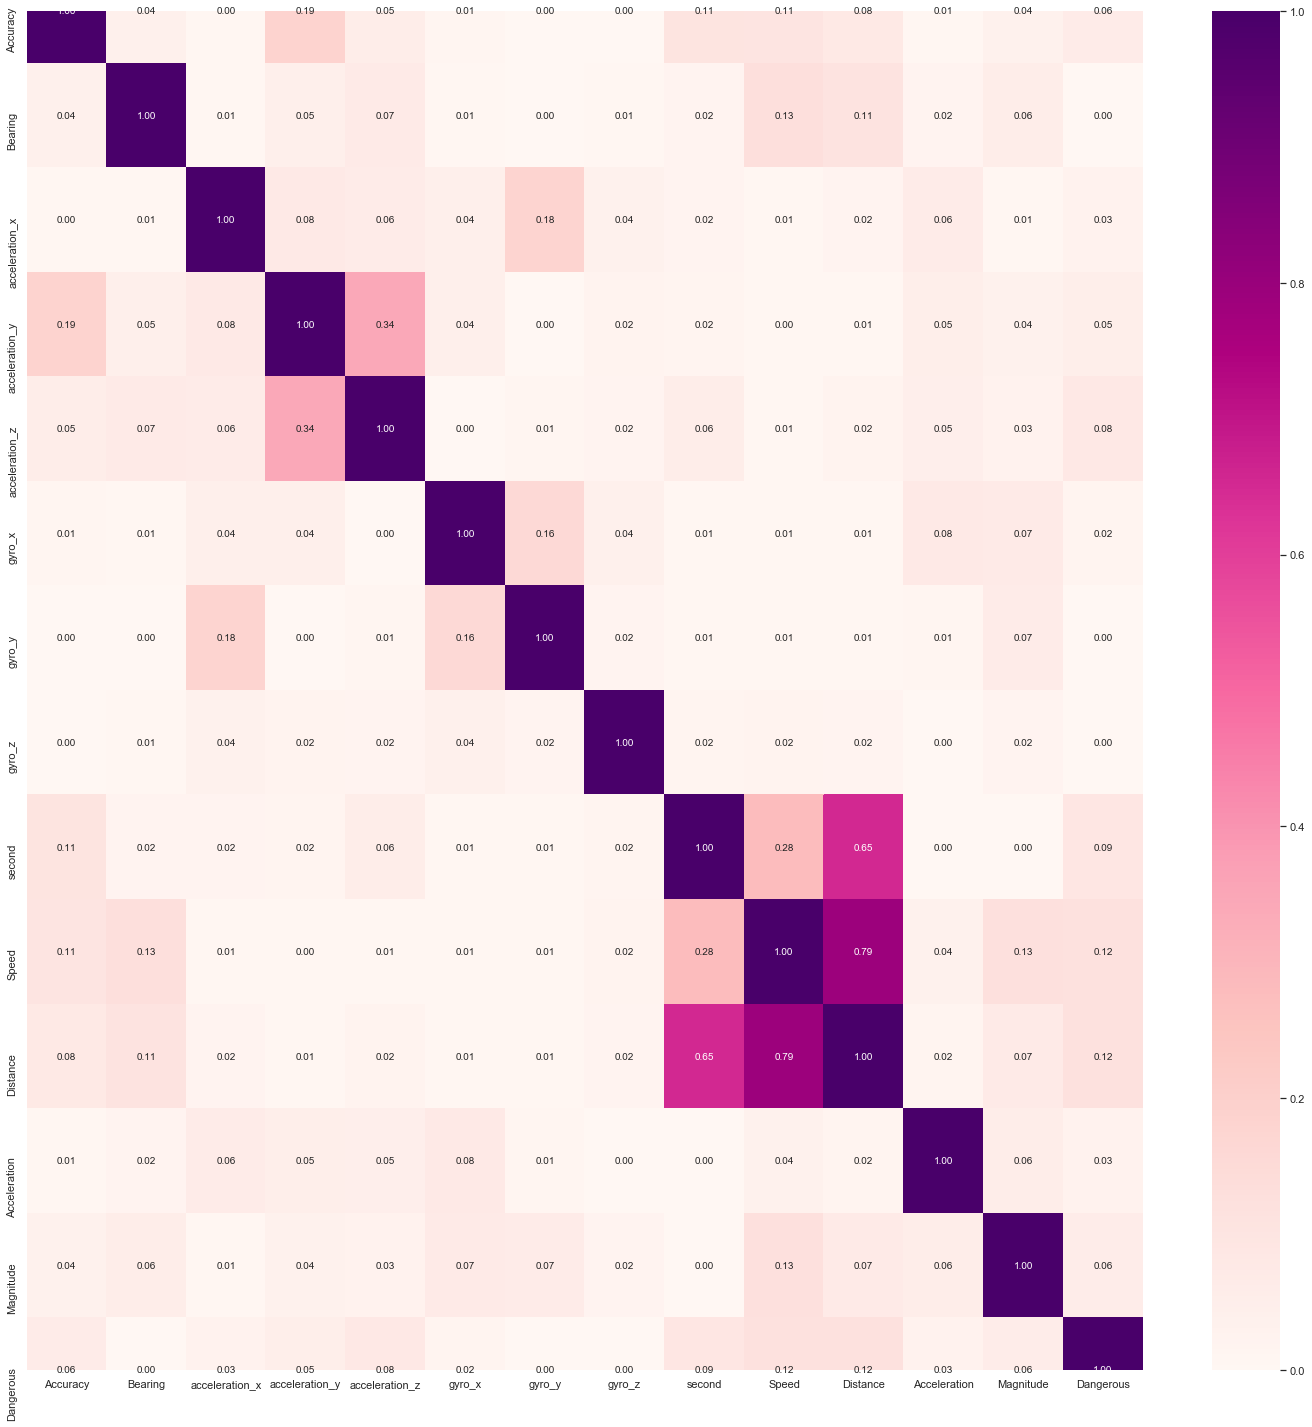

In [34]:
f, axes = plt.subplots(1, 1, figsize=(25, 25))
sb_heatmap = sb.heatmap(data.drop('bookingID', 1).corr().abs(), vmin = 0, vmax = 1, annot = True, fmt = ".2f", cmap="RdPu", cbar=True)

# 3. Prediction

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def runModel(estimators, criterion, drawGraph):
    columns = ["Accuracy", "Bearing", "Acceleration", "Magnitude", "Speed", "second"]
    
    y = data["Dangerous"]
    X = pd.DataFrame(data[columns])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

    m = RandomForestClassifier(n_estimators=estimators, criterion=criterion)
    m.fit(X_train, y_train)

    y_train_pred = m.predict(X_train)
    y_test_pred = m.predict(X_test)

    
    if(drawGraph):
        f, axes = plt.subplots(1, 2, figsize=(24, 12))
        axes[0].scatter(y_train, y_train_pred, color = "blue")
        axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
        axes[0].set_xlabel("True values of the Response Variable (Train)")
        axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
        axes[1].scatter(y_test, y_test_pred, color = "green")
        axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
        axes[1].set_xlabel("True values of the Response Variable (Test)")
        axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
        plt.show()

        print("Goodness of Fit of Model \tTrain Dataset")
        print("Explained Variance (R^2) \t:", m.score(X_train, y_train))
        print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
        print()

        print("Goodness of Fit of Model \tTest Dataset")
        print("Explained Variance (R^2) \t:", m.score(X_test, y_test))
        print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
        print()
        
        feat_importances = pd.Series(m.feature_importances_, index=data[columns].columns)

        f, axes = plt.subplots(1, 1, figsize=(10, 5))
        feat_importances.nlargest(10).plot(kind='barh')
    
    return [estimators, m.score(X_train, y_train), m.score(X_test, y_test), criterion]

In [37]:
results = []

results.append(runModel(10, 'gini', False))
results.append(runModel(25, 'gini', False))
results.append(runModel(50, 'gini', False))
results.append(runModel(100, 'gini', False))
results.append(runModel(200, 'gini', False))

results.append(runModel(10, 'entropy', False))
results.append(runModel(25, 'entropy', False))
results.append(runModel(50, 'entropy', False))
results.append(runModel(100, 'entropy', False))
results.append(runModel(200, 'entropy', False))

In [2]:
results = pd.DataFrame(data=results, columns=['n_estimators', 'R^2 (Train)', 'R^2 (Test)', 'Criteria'])

f, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = sb.barplot(results['n_estimators'], results['R^2 (Test)'], hue=results['Criteria'])
ax.set(ylim=(0.85, 1))

NameError: name 'pd' is not defined

# 3.1. Setting model parameters
As seen from the barchart above, increasing the estimators beyond 25 does not make a significant impact on the overall accuracy. Moreover, using entropy as the criteria seems to yield higher accuracy.

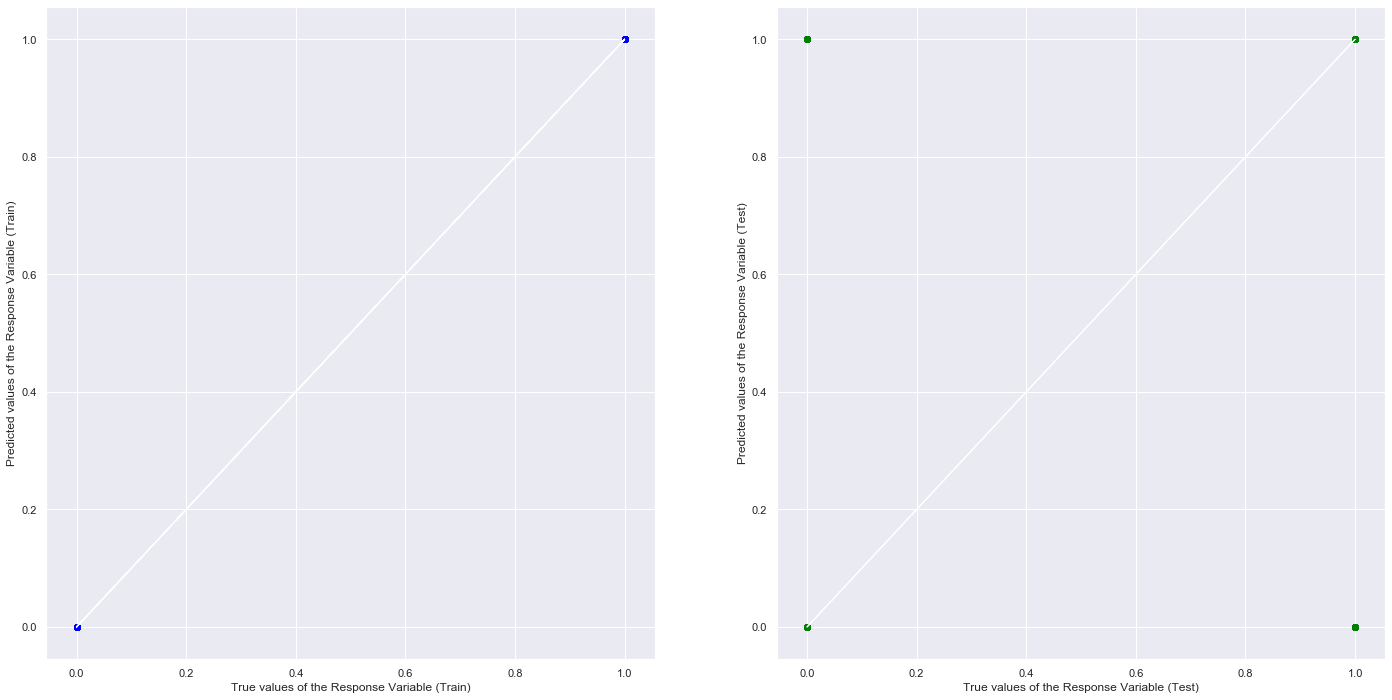

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 1.0
Mean Squared Error (MSE) 	: 0.0

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.929585087191822
Mean Squared Error (MSE) 	: 0.07041491280817799



[200, 1.0, 0.929585087191822, 'entropy']

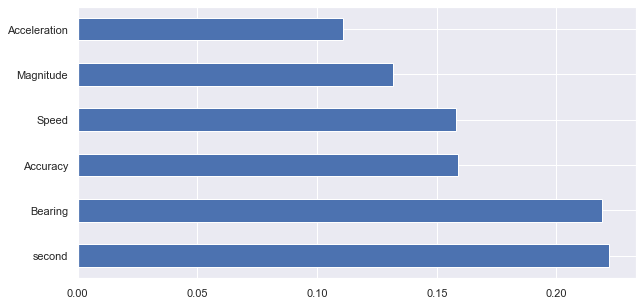

In [39]:
runModel(200, 'entropy', True)

## 3.2. Tweaking the model
Since the accuracy of the train dataset is significantly higher than the test dataset, the model is overfit and some estimators need to be removed.

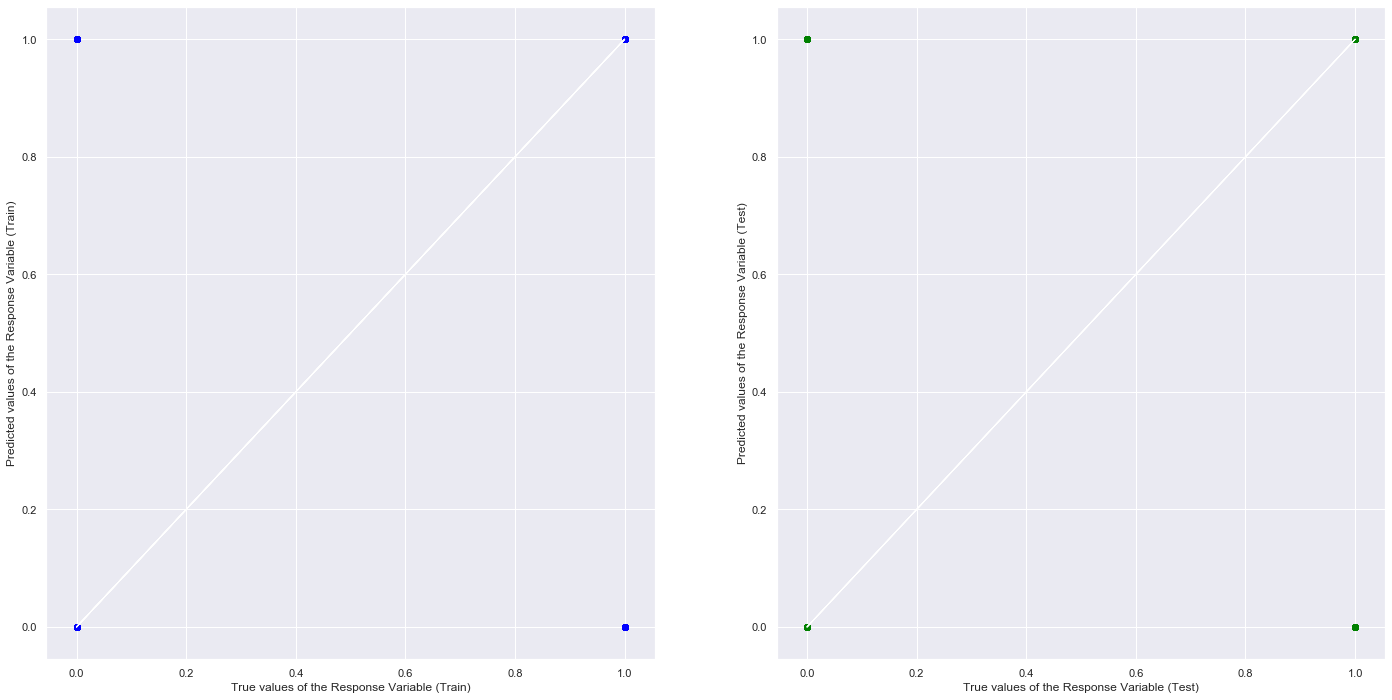

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9962200611662829
Mean Squared Error (MSE) 	: 0.003779938833717054

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.9571840923669018
Mean Squared Error (MSE) 	: 0.04281590763309814



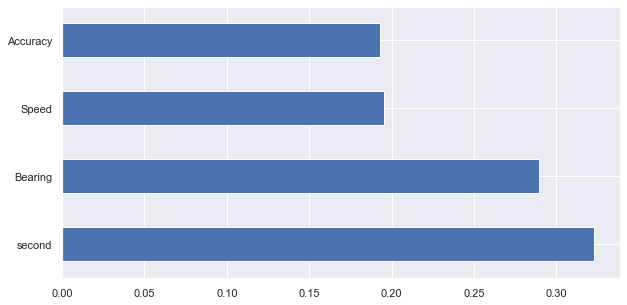

In [40]:
columns = ["Accuracy", "Speed", "second", "Bearing"]

y = data["Dangerous"]
X = pd.DataFrame(data[columns])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

m = RandomForestClassifier(n_estimators=25, criterion='entropy')
m.fit(X_train, y_train)

y_train_pred = m.predict(X_train)
y_test_pred = m.predict(X_test)


f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'w-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'w-', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", m.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", m.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()
    
feat_importances = pd.Series(m.feature_importances_, index=data[columns].columns)

f, axes = plt.subplots(1, 1, figsize=(10, 5))
feat_importances.nlargest(10).plot(kind='barh')